In [53]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# LCL plant
Vg = 127
fg = 60
wg = 2 * np.pi * fg
fsw = 24e3
fs = 48e3
Ts = 1 / fs

P = 1e3
Vmax = Vg * np.sqrt(2)
Imax = P / (Vg * np.sqrt(2))
Vdc = 225
L1 = 1.0e-3
L2 = 0.3e-3
Cf = 5e-6
Rc = 4.7

Lg1 = 1.44e-3
Cg1 = 139e-9
Lg2 = 2.88e-3
Cg2 = 276e-9

# fLCL = 1/(2*np.pi)*np.sqrt((L1+L2)/(L1*L2*Cf))  # w/o grid
fLCLg1 = 1 / (2 * np.pi) * np.sqrt((L1 + L2 + Lg1) / (L1 * (L2 + Lg1) * Cf))  # with grid 1
fLCLg2 = 1 / (2 * np.pi) * np.sqrt((L1 + L2 + Lg2) / (L1 * (L2 + Lg2) * Cf))  # with grid 2, lower fLCL
fLCLmin = 1 / (2 * np.pi) * np.sqrt(1 / (L1 * Cf))
fLCLmax = 1 / (2 * np.pi) * np.sqrt((L1 + L2) / (L1 * L2 * Cf))

ki = 1 / Imax  # Current sensor gain

In [54]:
# Open-loop transfer function OL(s)
Aa = 1
Zc = Rc + ctrl.TransferFunction([1], [Cf, 0])
dl = ctrl.TransferFunction([-0.5 * Ts, 1], [0.25 * Ts**2, Ts, 1])
dl

TransferFunction(array([-1.04166667e-05,  1.00000000e+00]), array([1.08506944e-10, 2.08333333e-05, 1.00000000e+00]))

In [55]:
tfL1C = Zc * ctrl.TransferFunction([1], [L1, 0])
H1 = ctrl.feedback(tfL1C, 1) * ctrl.TransferFunction([1], [L2, 0])

tfPOWdir = Vdc * dl * H1
tfPOWfb = ctrl.TransferFunction([L1, 0], 1) / (Vdc * dl)
H2 = ctrl.feedback(tfPOWdir, tfPOWfb)

Gp = H2 * ki * Aa
print(Gp)

<TransferFunction>: sys[190]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                    2.319e-11 s^3 - 3.465e-06 s^2 + 0.02425 s + 9093
-----------------------------------------------------------------------------------------
-3.815e-25 s^6 - 4.439e-20 s^5 + 2.439e-15 s^4 + 3.774e-10 s^3 + 9.921e-06 s^2 + 0.2925 s



### Controller 2.0

In [56]:
wc = 2 * np.pi * 1200  # fg*h < fc < fLCL
PM = 60  # higher damping
sc = 1j * wc



#### >>Without controller

Text(0.5, 0.98, 'Open loop w/o controller')

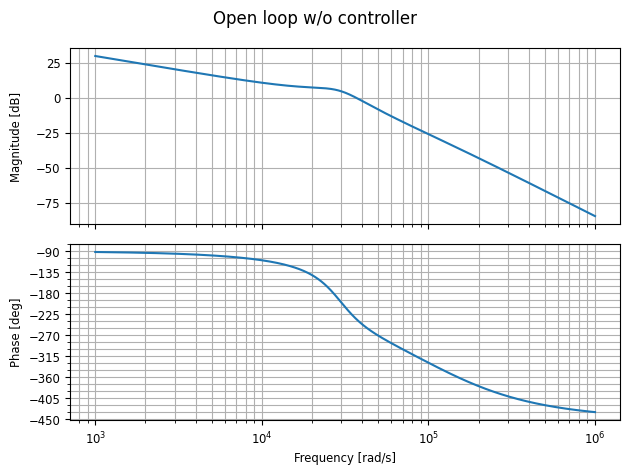

In [57]:

CPR = 1
OLpre = CPR * Gp  # Open loop without controller
magOL = abs(ctrl.evalfr(OLpre, sc))
phOL = np.angle(ctrl.evalfr(OLpre, sc)) * 180 / np.pi  # degrees

plt.figure(1)
ctrl.bode_plot(OLpre, dB=True)
plt.grid(True)
plt.suptitle('Open loop w/o controller')


In [58]:

print("=== w/o controller ===")
print(wc)
print(magOL)
print(phOL)
print("MF", phOL + 180)
print("======================")

=== w/o controller ===
7539.822368615503
4.389021937933807
-104.161811241557
MF 75.838188758443


#### >>With controller

In [59]:
# Resonant gain for h=1
R1_nd = ctrl.TransferFunction([1, 0], [1, 0, (1 * wg)**2])
R3_nd = ctrl.TransferFunction([1, 0], [1, 0, (3 * wg)**2])
R7_nd = ctrl.TransferFunction([1, 0], [1, 0, (7 * wg)**2])

# Proportional gain
kpc = abs(np.cos((PM - phOL - 180) * np.pi / 180)) / magOL  # sets 'wc' as the gain crossover freq (cutoff freq)

# ki per resonant element:
ki_c = abs(np.sin((PM - phOL - 180) * np.pi / 180)) / magOL / 3
ki1_c = (wc * wc - 1 * 1 * wg * wg) / wc
ki3_c = (wc * wc - 3 * 3 * wg * wg) / wc
ki7_c = (wc * wc - 7 * 7 * wg * wg) / wc

CPR = kpc + ki_c * ki1_c * R1_nd + ki_c * ki3_c * R3_nd + ki_c * ki7_c * R7_nd

=== ControllerPhase ===
-15.838188758442978
=== With controller ===
1.0
-119.99999999999997


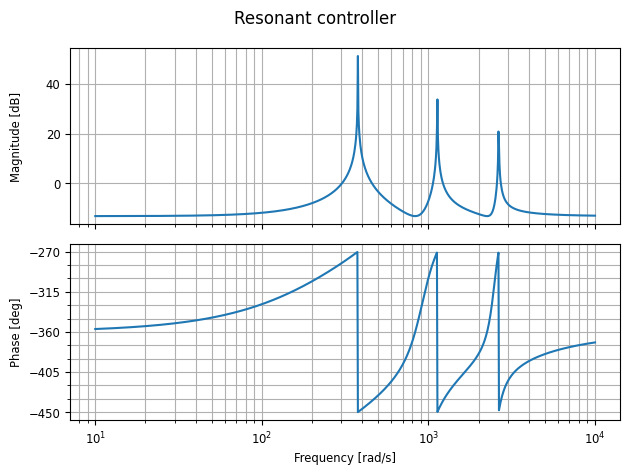

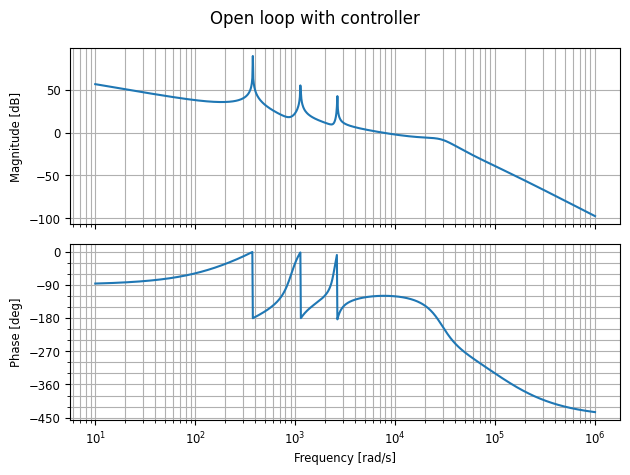

In [60]:
plt.figure(2)
ctrl.bode_plot(CPR, dB=True)
plt.grid(True)
plt.suptitle('Resonant controller')
print("=== ControllerPhase ===")
print(np.angle(ctrl.evalfr(CPR, sc)) * 180 / np.pi)
print("=======================")

OL = CPR * OLpre
plt.figure(3)
ctrl.bode_plot(OL, dB=True)
plt.grid(True)
plt.suptitle('Open loop with controller')
print("=== With controller ===")
print(abs(ctrl.evalfr(OL, sc)))
print(np.angle(ctrl.evalfr(OL, sc)) * 180 / np.pi)
print("=======================")

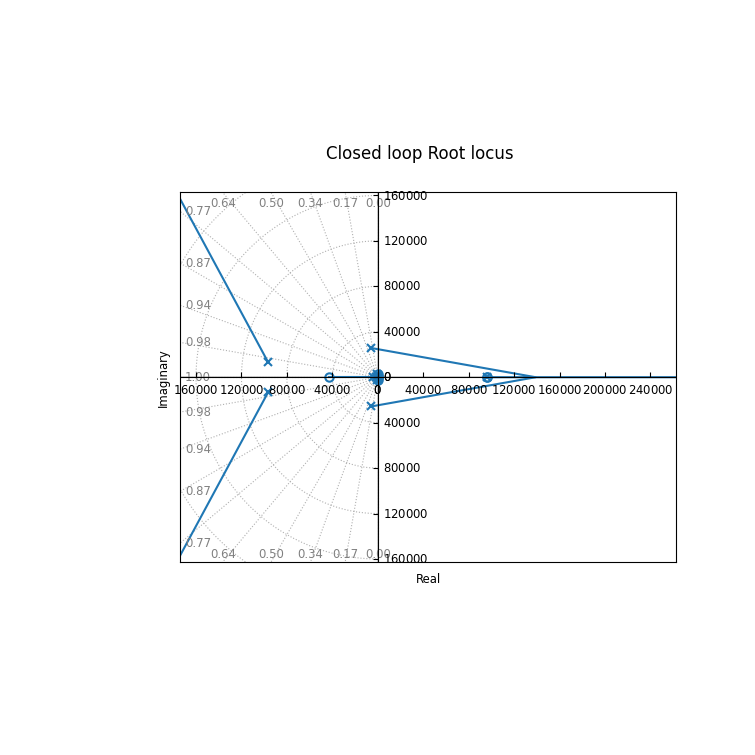

In [68]:
# --- CLOSED LOOP ---
CL = ctrl.feedback(CPR * H2, ki * Aa)
plt.figure(4)
ctrl.rlocus(CL)
plt.suptitle('Closed loop Root locus')
plt.grid(True)


plt.show()